# Paso 2: Cargar y Preprocesar los Datos

Cargaremos y preprocesaremos el dataset como lo hicimos en las secciones anteriores.

In [1]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar el dataset de Breast Cancer
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target, name='target')

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Paso 3: Definir la Función Objetivo para Optuna

La función objetivo define el problema de optimización y devuelve una métrica de evaluación que Optuna intentará minimizar o maximizar.

In [2]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def objective(trial):
    # Definir los hiperparámetros a optimizar
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 50, 300)
    
    # Crear el modelo de Regresión Logística con los hiperparámetros sugeridos
    model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter, random_state=42)
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular la exactitud
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

c:\Users\edgar\miniforge3\envs\machine_learning_ds02\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Paso 4: Ejecutar la Optimización con Optuna

Ejecutamos el proceso de optimización utilizando el método optimize de Optuna.

In [3]:
# Crear un estudio de Optuna y optimizar la función objetivo
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(study.best_params)

# Mostrar la mejor exactitud obtenida
print(f"Mejor exactitud obtenida: {study.best_value}")


[I 2024-11-24 15:36:19,791] A new study created in memory with name: no-name-e9e96660-11b8-4b96-8fd4-d166e27879ca
C:\Users\edgar\AppData\Local\Temp\ipykernel_11748\2370919033.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
c:\Users\edgar\miniforge3\envs\machine_learning_ds02\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-11-24 15:36:19,828] Trial 0 finished with value: 0.9736842105263158 and parameters: {'penalty': 'l1', 'C': 1.3238349451314748, 'solver': 'saga', 'max_iter': 91}. Best is trial 0 with value: 0.9736842105263158.
C:\Users\edgar\AppData\Local\Temp\ipykernel_11748\2370919033.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This featur

Mejores hiperparámetros encontrados:
{'penalty': 'l2', 'C': 0.038108244948323475, 'solver': 'liblinear', 'max_iter': 131}
Mejor exactitud obtenida: 0.9912280701754386


# Paso 5: Evaluar el Mejor Modelo

Evaluamos el mejor modelo encontrado por Optuna utilizando las métricas de evaluación vistas anteriormente.

Exactitud del mejor modelo: 0.9912280701754386
Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Matriz de Confusión:
[[42  1]
 [ 0 71]]


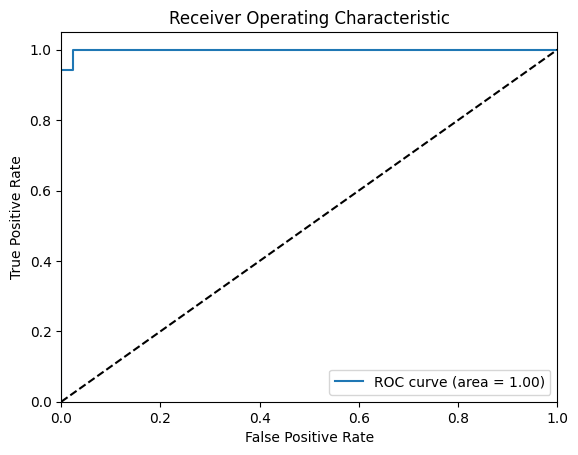

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
# Obtener el mejor modelo
best_params = study.best_params
best_model = LogisticRegression(**best_params, random_state=42)

# Entrenar el mejor modelo
best_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud del mejor modelo: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(conf_matrix)

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()